In [1]:
# magics 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Fellowship.ai Challenge: ULMFiT applied to the Twitter US Airline Sentiment dataset

## Transfer learning is no longer limited to computer vision

Universal Language Model Fine-tuning (ULMFiT), a novel approach towards applying transfer learning to natural language processing tasks, was originally introduced by Jeremy Howard and Sebastian Ruder in early 2018.  

Transfer learning is a method that takes advantage of models that have already been pre-trained to learn a given task on large datasets and re-purposes them to learn a (new) related task. This dramatically reduces the amount training data and time needed to train a model.

Howard and Ruder demonstrated that transfer learning, which had previously only been successful with computer vision problems, can be applied to natural language processing tasks as well. At the time of ULMFiT's initial release, it outperformed the state-of-the-art on six text classification benchmarks. 

<strong>Classifying the sentiment of tweets</strong>

This notebook is a documented attempt at creating an ULMFiT model that can correctly classify the sentiment of tweets from from the [Twitter US Airline Sentiment dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). The data consists of 14640 labeled tweets directed at six major US airline companies (Virgin America, United, Southwest, Delta, US Airways and American Airlines). We will train a model to identify whether the tweets are positive, neutral or negative. 

Without transfer-learning and ULMFiT, this task would have been considered to be very challenging due to the small dataset size. 14640 tweets is regarded as small, given that previous attempts to fine-tune language models required millions of in-domain documents to achieve an acceptable performance [(Dai and Le 2015)](http://arxiv.org/abs/1511.01432). We also need to take into account that tweets are relatively short text samples, meaning that the model has less information to work with relative to longer documents like IMDB movie reviews. (Tweets were still limited to 140 characters at the time the data was collected.)

Preliminary data-exploration showed that the dataset is highly imbalanced, with the negative tweets amounting to more than the positive and neutral tweets combined with 9178 negative tweets, 3099 neutral tweets and 2363 positive tweets respectively.    

A study by [Buda et al.](https://arxiv.org/pdf/1710.05381.pdf) demonstrated that class imbalance significantly decreases the performance of CNNs (Convolutional Neural Network), an architecture primarily used for computer vision tasks. As such it is very likely that the class imbalance of this dataset may have a negative impact on model performance as well. 

<strong>Creating a multi-label classifier with data-augmentation and ensembles</strong>


We will try solving this multi-label classification problem according to the approach outlined in following steps::

1. Create a artificially balanced dataset using nlp data-augmentation.
2. Fine-tune an AWD-LSTM language model trained on the Wikitext 103 corpus to the data-augmented airline sentiment dataset to train bi-directional language model (an ensemble of the forward and backward language models).
3. Train two separate text classifiers using both the forward and backward language model encoders to create an ensemble classification model.

References:

1. [Andrew M. Dai and Quoc V. Le. 2015. Semi- supervised Sequence Learning. Advances in Neu- ral Information Processing Systems (NIPS ’15)](https://arxiv.org/abs/1511.01432)
2. [Mateusz Buda, Atsuto Maki, and Maciej A Mazurowski. A systematic study of the class imbalance problem in convolutional neural networks](https://arxiv.org/pdf/1710.05381.pdf)


## Model Evaluation

<em>Error Rate</em> 

In order to get a good understanding of how the model is performing, I've opted to use accuracy and a weighted f1 score to evaluate model performance. The F1 score was included, because accuracy can be misleading when working with imbalanced datasets. Note: Consider user error-rate instead because it's what's used in the ULMFiT paper 

In order to get an understanding of how well our model is performing, I’ve decided to use the error rate (1-accuracy) to evaluate the model’s  performance. This way it can be compared the the ULMFiT paper’s benchmark of a 5% validation error on the IMDb sentiment classification task  and other models.

<em>Classification Matrix</em>

We will also look at a classification confusion matrix, because accuracy can be a misleading performance indicator for models with imbalanced datasets.

> Before we start, we'll have to import couple of libraries and the data

In [2]:
# install nlp data augmentation library and dependencies
!pip install git+https://github.com/makcedward/nlpaug.git numpy matplotlib python-dotenv; pip install nltk

  Cloning https://github.com/makcedward/nlpaug.git to /tmp/pip-req-build-p_6oj_ai
  Running command git clone -q https://github.com/makcedward/nlpaug.git /tmp/pip-req-build-p_6oj_ai
  Created wheel for nlpaug: filename=nlpaug-0.0.9-cp36-none-any.whl size=81585 sha256=18a6c713fc0f668bd9494079727b53f4e7a59202e487b8b6d99a8f666ebbf222
  Stored in directory: /tmp/pip-ephem-wheel-cache-fu_dnzp1/wheels/2b/ef/30/a4e22f9a97373c9ab6763670c94aa5e111b0b956983f3892a4
Successfully built nlpaug


In [3]:
# fastai library
from fastai import *
from fastai.text import *
# plotting confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# nlp word augmentation libraries
import nlpaug.augmenter.word as naw
from nlpaug.util import Action

# classification report
from sklearn.metrics import classification_report

In [4]:
# set data path
path = Path('../input/twitter-airline-sentiment')
path.ls()

[PosixPath('../input/twitter-airline-sentiment/database.sqlite'),
 PosixPath('../input/twitter-airline-sentiment/Tweets.csv')]

In [5]:
# create pandas dataframe and 
df = pd.read_csv(path/'Tweets.csv')

### Data Exploration

We'll start by looking at the shape and a few examples of the dataset

The dataset has 14640 rows and 15 columns. For our ULMFiT model we will only be using the <code>text</code> and <code>airline_sentiment</code> columns. 

In [6]:
# check dataframe shape
df.shape

(14640, 15)

In [7]:
# look at first 5 data samples
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Next we'll create some visualizations to explore the data 

In [8]:
# Check number of posible lables
senti_types = df['airline_sentiment'].unique()
print('No. of sentiment labels: {}'.format(len(senti_types)))

No. of sentiment labels: 3


In [9]:
# set graph style
sns.set(palette='Pastel2', style='dark')

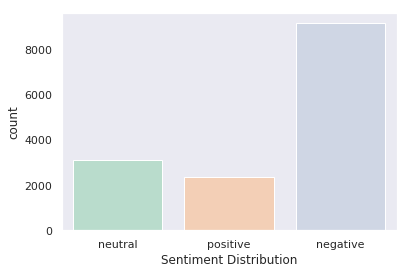

airline_sentiment
negative    9178
neutral     3099
positive    2363
dtype: int64

In [10]:
# Plot class distribution
dist = df.groupby('airline_sentiment')

# plot label distribution to see if dataset is un-balanced
sns.countplot(df.airline_sentiment)
plt.xlabel('Sentiment Distribution')
plt.show()

dist.size()

### Class distribution

The classes distribution is very imbalanced with the dataset comprising of more negative tweets than neutral and positive tweets combined. 

>It wouldn't be unreasonable to assume that people are far less likely to tweet about an airline if it's not a complaint. 

The next section isn't necessarily relevant to the ULMFiT model. Feel free to skip ahead to the Algorithms &amp; Tenchiques section of this notebook. 

We will visualize other observations made when looking at the data such as: 

1. Which airline was mentioned the most and is this proportional to the market capitalization of the airline?
2. Sentiment distribution by airline
3. The top 3 reasons for a complaint
4. Cause of complaints by airline

### Which Airline was the most popular on Twitter in 2015?

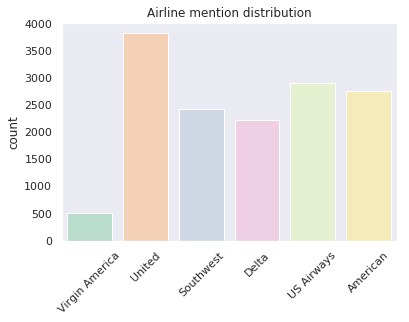

In [11]:
# plot how often an airline has been mentioned
sns.countplot(df.airline)
plt.title('Airline mention distribution')
plt.tick_params(axis='x', rotation=45)
plt.xlabel('')
plt.show()

When looking at the graph above it's interesting to see that the number of tweets isn't proportional to the market capitalization of the companies.

Market capitalization of airlines in billions of U.S. dollars: Sept 17 2019 

[Source | https://www.statista.com/statistics/275948/market-capitalization-of-selected-airlines](https://www.statista.com/statistics/275948/market-capitalization-of-selected-airlines/)

1. Delta 38.41
2. Southwest 30.00
3. United 23.5
4. American Airlines + US Airways 12.3
5. Virgin America 2.55

<em>This needs to be taken with a grain of salt because the data is from 2015 and the market cap. figures are from 2017</em>

In [12]:
print('Tweet distribution by airline \n', df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))

Tweet distribution by airline 
 airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


### Sentiment Distribution by Airline

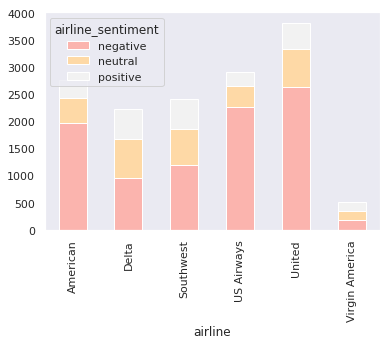

In [13]:
df.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar', stacked=True, colormap='Pastel1' )

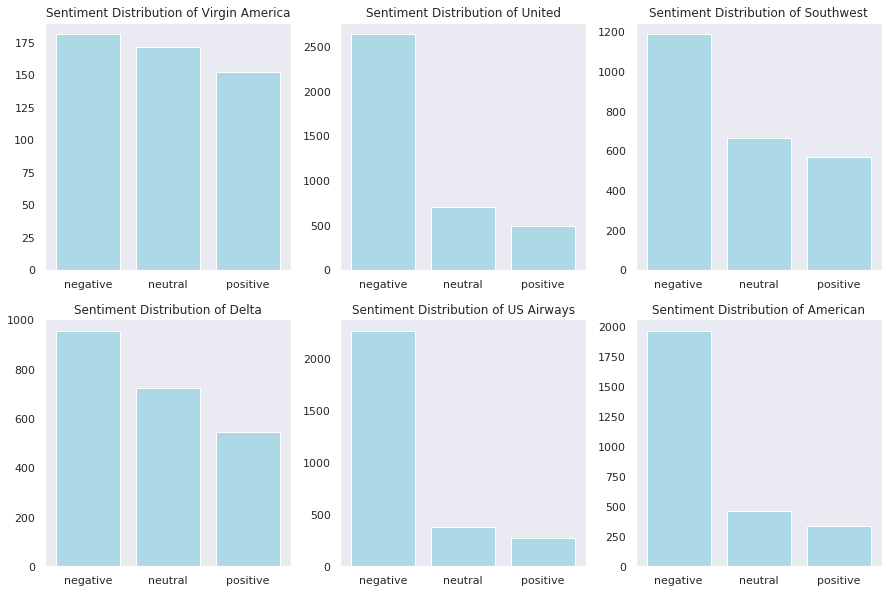

In [14]:
# sentiment distribution by airline
plt.figure(1, figsize=(15,10))
airlines = list(df['airline'].unique())
for i in df.airline.unique():
    idxs = airlines.index(i)
    plt.subplot(2,3,idxs+1)
    pl_df = df[df.airline==i]
    count = pl_df['airline_sentiment'].value_counts()
    index = [1,2,3]
    plt.bar(index, count, color='lightblue')
    plt.xticks(index, ['negative','neutral','positive'])
    plt.ylabel('')
    plt.title('Sentiment Distribution of ' + i)

Negative sentiment tends to outweigh the other classes for all airlines.

Twitter sentiment towards American Airlines, US Airways and United Airways appears to be mainly negative.

Delta and Southwest display more balanced sentiment distributions, whilst Virgin America has the most balanced sentiment distribution amongst the airlines. 



## Quantifying Customer Complaints

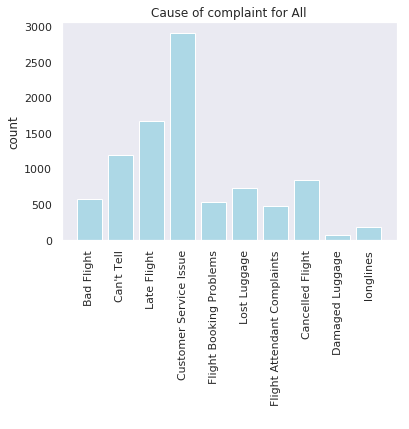

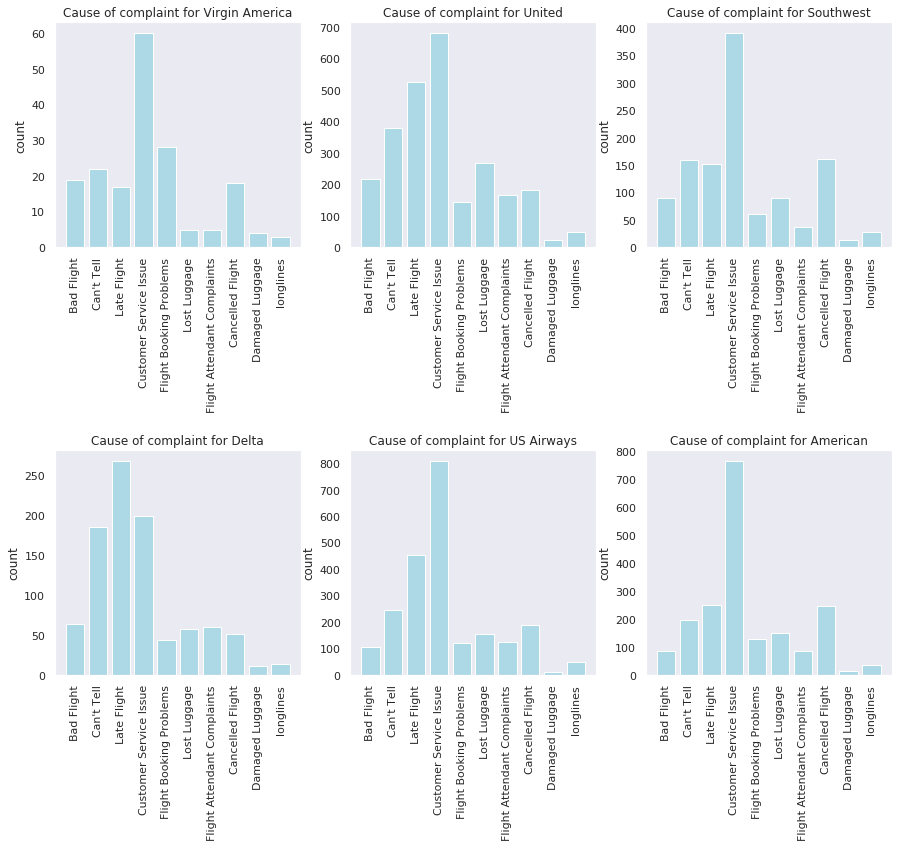

In [15]:
#get the number of negative reasons
df['negativereason'].nunique()

nr_count = dict(df['negativereason'].value_counts(sort=False))
def reason_count(airline):
    if airline=='All':
        a = df
    else:
        a = df[df['airline']==airline]
    count = dict(a['negativereason'].value_counts())
    unique_reason=list(df['negativereason'].unique())
    unique_reason=[x for x in unique_reason if str(x) != 'nan']
    reason_frame=pd.DataFrame({'reasons':unique_reason})
    reason_frame['count']=reason_frame['reasons'].apply(lambda x: count[x])
    return reason_frame

def plot_reason(airline):
    
    a = reason_count(airline)
    count = a['count']
    index = range(1,(len(a)+1))
    plt.bar(index,count, color='lightblue')
    plt.xticks(index,a['reasons'],rotation=90)
    plt.ylabel('count')
    plt.xlabel(' ')
    plt.title('Cause of complaint for ' + airline)
    
plot_reason('All')
plt.figure(2,figsize=(15, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

#### Top 3 Airlines - Most Late Flight Complaints
1. Delta
2. United
3. US Airways

#### Top 3 Airlines - Most Lost Luggage Complaints

1. United 
2. Southwest
3. Delta

## Algorithms &amp; Techniques

This section outlines the techniques used to improve model performance in addition to the methods suggested by the ULMFiT paper.

<strong>Data Augmentation using "Synonym Word Replacement"</strong>

I initially tried to create a classifier with the ULMFiT approach outlined in [this notebook](https://github.com/fastai/fastai/blob/master/examples/ULMFit.ipynb) by Sylvain Gugger, which achieves a 4.6% validation error on the [IMDB movie reviews dataset](http://ai.stanford.edu/~amaas/data/sentiment). I also tried the method proposed in the [fast.ai NLP MOOC](https://www.youtube.com/playlist?list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9). Both attempts got nowhere close to a 4.6% error rate. 

One should note that the IMDB dataset only has two classes to predict (one less than our Airline Sentiment dataset) and a significantly larger dataset size, making it "easier" to achieve lower error rates.

I suspected that the class imbalance may be one of the reasons behind the initial validation accuracy of 28.7 (> 80% error rate!?!) the first few models were returning.  I’ve also been wanting to explore how data augmentation could be applied to NLP problems. After some research I chanced upon an [open source library built for NLP data augmentation](https://github.com/makcedward/nlpaug) called nlpaug by Edward Ma.

The library has a function that creates new text samples by replacing words in the origial text with their synonyms.  

<em>Examples of positive and neutral tweets generated by the model</em>

<em>positive tweets</em>

<code>Original: @SouthwestAir now flying non stop CMH-OAK has me daydreaming<br> about a trip to the bay...especially in this weather. #OhioProbz</code>

<code>Augmented: @SouthwestAir instantly flying non stop CMH-OAK has me daydreaming<br> about a slip to the bay...especially in this weather. #OhioProbz</code>

<em>neutral tweets</em>

<code>Original: @AmericanAir forgot to select my ksml on my flight to LA and<br> it's a few minutes under the 24 hour mark. Is there any way to change it?</code>

<code>Augmented: @AmericanAir forgot to select my ksml on my flying to LOUISIANA and<br> it's a few minutes under the 24 60 minutes mark. Be there any way to shift it?</code>

We will try to balance the dataset classes using data-augmentation. The idea is to generate enough positive and neutral tweets using synonym word replacements to match the negative tweets, instead of handling the imbalance by subsampling or simply creating duplicate copies of the original data. 

I’m hoping for this to create more variety in the dataset, which may in turn help the model generalize better. 
In theory creating new tweets via synonym replacement should maintain the sentiment of the original tweets.


<strong>ULMFiT: Transfer Learning and fine-tuning an AWD LSTM Language Model</strong>

To build our sentiment classifier we will make use of a model that has trained on a larger and more diverse dataset and “fine-tune” it to learn how to solve our classification problem.

In computer vision, models that have been trained to tell the difference between a thousand different classes (using millions of Imagenet images) are fine-tuned to do medical-image screening tasks like [diagnosing causes for blindness](https://ai.googleblog.com/2016/11/deep-learning-for-detection-of-diabetic.html).

One of the key discoveries of the ULMFiT paper is that a pre-trained AWD-LSTM language model is NLP’s equivalent to the pre-trained Imagenet model in computer vision, meaning that it serves as a good base model to transfer knowledge from.

Language models are models used to predict the next n elements in a sequence, like the next word in a sentence for example.

Howard and Ruder reasoned that [Stephen Merity’s AWD LSTM language model](https://arxiv.org/abs/1708.02182) (which outperformed previous approaches to language modeling by a significant margin) would inherently need to have a more complete and implicit understanding of natural language and it’s semantics in order to learn how to predict the next word(s) in a sentence. 

At a high level the ULMFiT approach can be summarized in the following 3 steps:

1. Use a general and large langauge corpus, like Stephen Merity's Wikitext 103 dataset, which contains a pre-processed subset of the English wikipedia to train a language model. 
2. Fine-tune the langauge model on our target langauge corpus (in this case our 14640 tweets). We’re training a model that can predict the next n words in a tweet.
3. Use the langauge model's encoder to train a classifier that can distinguish between negative, positive and neutral tweets.

>Wikitext103 consists of 28,595 articles and 103 million words

<strong>Ensemble Training</strong>

To further increase the potential performance of our model, we will train not one but two classifiers to predict the sentiment of a tweet by training both a forward and a backward langauge model and classifier. A forward model is simply a regular language model that predicts the next word in a sentence. A backward model does the same but backwards, meaning that it predicts the previous word in a sentence given the words that that follow the predicted word. The idea is that the two models combined will have even more implicit knowledge about the language. The resulting prediction will be the mean of the two classifier predictions. 

The paper states that the impact of bi-directionality at the cost of training a second model and ensembling the predictions of a forward and backwards LM-classifier brings a performance boost of around 0.5–0.7, lowering the test error from 5.30 of a single model to 4.58 for the bi-directional model.

<strong>Techniques used to fine-tune the language model</strong>

<em>Discriminative fine-tuning</em>

Because different layers capture different types of information [(Yosinski et al., 2014)](https://arxiv.org/abs/1411.1792), they should be fine-tuned to different extents. The authors of the ULMFiT paper propose a novel fine-tuning method called discriminative fine-tuning. Instead of using the same learning rate for all layers of the model, discriminative fine-tuning allows for the tuning of each layer with different learning rates.



The authors of the ULMFiT paper stated that langauge-model fine-tuning had previously been very difficult, as they tend to overfit to small datasets and suffer from some form of deep learning amnesia (catastrophic forgetting) when fine-tuned with a classifier. 

The following techniques are further suggested methods for fine-tuning a language model with a classifier:

- Slanted triangular learning rates
- Gradual unfreezing

<em>These methods are described in greater detail in the model implementation section of this notebook.</em>

## Benchmark

In addition to keeping the 4.6% validation error rate from the ULMFiT paper in mind, I decided on using the Kaggle notebook linked below as a benchmark for our ULMFiT model, as it was one of the highest ranked Kaggle notebooks with the ULMFiT approach applied to our [target dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). The benchmark notebook uses 15% of the data for the test set and reports a test accuracy of 82.78% or an error rate of 17.2%. 

[Benchmark Link: Twitter-Us-Airlines-Sentiment-With-Ulmfit-Approach](https://www.kaggle.com/davidbankom/twitter-us-airlines-sentiment-with-ulmfit-approach)

## Data Preprocessing

Before training the data needs to be tokenized and turned into a numericalized representation so that the model can make use of the data.

Tokenization refers to chopping up phrases, sentences, paragraphs or entire text documents into smaller units like words.

This is done using the following pre-processing rules before tokenization:
- substituting html ```<br>``` tags with <code>\n</code> 
- adding spaces before and after hashes<code>#</code> and slashes<code>/</code>
- removing additional spaces
- replacing character and word repetitions with repetition tokens, for example: <code>cccc</code> is converted to <code>TK_REP 4 c</code> or <code>repetition repetition repetition</code> with <code>TK_WREP 3 repetition</code>
- further string cleaning methods

...and adding some additional meta-data tokens so that can help the model learn better:

- tokens that indicate the beginning and the end of a sentence
- tokens that indicate capitalization and ALL CAPS spelling
- tokens that indicate padding to ensure data-input consistency

The tokenization process itself is handled using the [spacy tokenizer](https://spacy.io/usage/linguistic-features#how-tokenizer-works), which uses spaces as the splitpoints for text documents.

Fastai also limits the total vocabluary of the training data by substituting rare words with the unk token. When looking at the pre-processed data, tokens can be recognized by the <code>xx</code> at the start of each token, <code>xxunk</code> is the token for unknown words, whilst <code>xxbos</code> is the token for the beginning of a sentence.

Further specifics and code on how the fastai library pre-processes text lists can be found [here](https://github.com/fastai/course-v3/blob/master/nbs/dl2/12_text.ipynb)




## Model Implementation

We'll beginn by removing the columns we won't be using from the dataframe and split our data into the a training and a test set with a 85/15 split ratio. We will keep the test set squirreled away for now so that we can later see how well our model generalizes.

In [16]:
# first we ensure that we're only working with the columns we need from the dataframe
df = df[['airline_sentiment', 'text']]

In [17]:
# determine split point
train_len = int(len(df)*0.85)

# set training dataframe
df_train = df[:train_len]

# set test dataframe
df_test = df[train_len:]

# test if split left samples behind
assert len(df) == sum([len(df_train), len(df_test)])

# print lengths
print(len(df_train), len(df_test), sum([len(df_train), len(df_test)]))

12444 2196 14640


Next we will split our training dataframe into positive, neutral and negative tweets to determine how many tweets to generate, which will be the difference between the negative and the positive tweets and the negative and the neutral tweets respectively.

In [18]:
df_pos = df_train.loc[df_train.airline_sentiment == 'positive']
df_neu = df_train.loc[df_train.airline_sentiment == 'neutral']
df_neg = df_train.loc[df_train.airline_sentiment == 'negative']

print('There are {} positive tweets, {} neutral tweets and {} negative tweets'.format(len(df_pos), len(df_neu), len(df_neg)))

There are 2129 positive tweets, 2774 neutral tweets and 7541 negative tweets


In [19]:
# calculate how many positive and neutral augmented tweets we want to create to balance the datasets
pos_aug = len(df_neg)-len(df_pos)
neu_aug = len(df_neg)-len(df_neu)

print('Tweets to create: {} postive tweets, {} neutral tweets'.format(pos_aug,neu_aug))

Tweets to create: 5412 postive tweets, 4767 neutral tweets


In [20]:
# data augmentation function

def train_aug(n_aug, source_df, train_df):
    # print and store initial df length
    train_len = len(train_df)
    print('Data length before augmentation: {} \n'.format(train_len))
    
    for n in range(n_aug):
        # get a random tweet from the source dataframe
        randn = random.randint(0, len(source_df)-1)
        row = source_df.iloc[randn].values
        # do synonym augmentation
        aug = naw.SynonymAug(aug_src='wordnet')
        augmented_text = aug.augment(row[1])
        # add new row to training dataframe
        new_row = {'airline_sentiment': row[0], 'text': augmented_text}
        train_df = train_df.append(new_row, ignore_index=True)
    
    new_added = len(train_df) - train_len
    # print 
    print('{} items added to training datafrane. Training dataframe now has {} rows'.format(new_added, len(train_df)))
    
    return train_df

In [21]:
# add postive tweets to training data
df_train = train_aug(pos_aug, df_pos, df_train)

Data length before augmentation: 12444 

5412 items added to training datafrane. Training dataframe now has 17856 rows


In [22]:
# add neutral tweets to training data
df_train = train_aug(neu_aug, df_neu, df_train)

Data length before augmentation: 17856 

4767 items added to training datafrane. Training dataframe now has 22623 rows


In [23]:
len_df_all = len(df_train) + len(df_test)
print('Train length: {}, Test length: {}, Combined data length {}'.format(len(df_train), len(df_test), len_df_all))

Train length: 22623, Test length: 2196, Combined data length 24819


To better train and improve language model fine-tuning we will use all the data to train our Airline Tweet language model by concatenating the train and test sets.

In [24]:
# concat train and test set for language model
df_lm = pd.concat([df_train, df_test])
print(len(df_lm))

24819


In [25]:
# set batchsize and backprop through time
bs = 256
bptt = 80

Next we will use the fastai datablock api to prepare the data for our langauge model with only 5% of the data in the validation set so it can learn as much as possible from our target langauge corpus.

In [26]:
# prepare/pre-process langauge model data
data_lm = (TextList.from_df(df_lm, cols='text')
                   .split_by_rand_pct(0.05, seed=42) # default for valid_pct=0.2, we're using 0.05, so we have more data to train lm
                   .label_for_lm() # the text is the label
                   .databunch())

In [27]:
# look at dataset length after split and pre-processing
print('Vocab size: {}, training set length: {}, validation set length: {}'.format(len(data_lm.vocab.itos), len(data_lm.train_ds), len(data_lm.valid_ds)))

Vocab size: 8208, training set length: 23579, validation set length: 1240


In [28]:
# save data
data_lm.save('data_lm.pkl')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [29]:
# look at data batch
data_lm.show_batch()

idx,text
0,"about it xxbos @virginamerica seriously would pay $ 30 a flight for seats that did n't have this playing . \n it 's really the only bad thing about flying xxup va xxbos @virginamerica yes , nearly every time i fly xxup vx this “ ear xxunk ” wo n’t go away :) xxbos @virginamerica xxmaj really missed a prime opportunity for xxmaj men xxmaj without xxmaj hats parody"
1,some help with a support ticket ? xxmaj it 's been 15 days xxrep 4 . xxmaj incident : xxunk - xxunk xxmaj thank you ! xxbos @virginamerica i can not even open my laptop in seat xxup xxunk and i paid a premium for this ? ! ! xxmaj let me out of here ! xxbos @virginamerica i am in seat xxup xxunk and i can not even open
2,"doors for "" premier passengers "" after safety xxunk on delayed flights . # annoyed . xxbos @united xxup dm sent xxbos @united yea get me to phoenix already . xxmaj delays all day with you people . xxmaj it 's bullshit . xxbos @united xxmaj if it 's any xxunk , your staff was stellar . xxmaj just not the hour+ delays i encountered with every one of my"
3,xxup cle - xxup sfo # xxunk . xxmaj you 're the xxup only airline w / out wifi ... and pls no ' xxunk ' xxup bs . xxbos @united u would not be able to rebook me to get home any sooner than a now 2hr delayed flight . # xxunk # customerservice # fail # again xxbos @united what a pointless tweet . xxmaj at least @americanair
4,our customers get better service ' xxbos @united xxmaj she is travelling from xxmaj xxunk ( xxmaj australia ) to xxmaj bogota ( xxmaj colombia ) tomorrow xxbos @united xxmaj hi . xxmaj my relative 's xxmaj flight xxmaj booking xxmaj problems number is xxup xxunk . xxmaj her name is xxmaj xxunk xxmaj xxunk xxmaj xxunk . xxmaj thank you xxbos @united it was delivered ! xxmaj thank you


Because we will be building a bi-directional model we want to create an instance of the data in reverse, luckily the [fastai library](https://docs.fast.ai) makes this very easy by loading the data with <code>backwards=True</code> 

In [30]:
# backward lm data - *the ../../working is specific to working in a Kaggle notebook
data_lm_bwd = load_data(path, '../../working/data_lm.pkl', bs=bs, bptt=bptt, backwards=True)

In [31]:
# let's look at the data in reverse
data_lm_bwd.show_batch()

idx,text
0,"called 's that xxmaj . flight xxmaj late xxmaj minutes 15 were we until communication or warnings no xxmaj . flight xxmaj late xxmaj minutes 20 over leaving @americanair xxbos 👌 delays the with cue on right @americanair xxbos . monday xxmaj arrive to need but flight night tuesday xxmaj a for rebooked auto xxmaj . morning tomorrow leaving , flightled xxmaj cancelled xxmaj was flight my @americanair xxbos 😂"
1,"customer a to response life real a this is how xxmaj xxunk @americanair xxbos . unreal level next is this because xxmaj . then , team that on people 3 , like , only 's there bad too xxmaj xxunk @americanair xxbos ! 5 xxrep tomorrow home get us help please @americanair xxbos ? issues weather xxunk is understaffing / incompetence that sorry or xxmaj ? way general a ,"
2,"“ xxbos xxunk # xxunk # ? plane another about how xxmaj ! ? ! plane the boarding before issue an troubleshoot to engine the run to have you @americanair xxbos mistakes xxunk - pre and , rudeness , understaffing with worse much xxup it making 're they xxmaj . xxunk xxmaj , it buy n't do xxmaj xxunk @americanair xxbos ! fees of list impressive an quite 's that"
3,"bags my take to have i xxunk , morning xxunk to xxunk xxup take 'll i , friday xxmaj next xxmaj @americanair xxbos ! please us xxunk ... mins 30 for tarmac the on xxunk xxup # in sitting been have we man @americanair xxbos . well crowd handled men young xxunk xxunk xxup gate at staff fabulous xxmaj . help no center phone flightled xxmaj cancelled xxmaj nashville xxmaj"
4,@americanair xxbos americanairlines # badmgmt # snow in drive n't could crew ground because 3hrs than more for sat lax xxup to iad xxup from 1081 flight @americanair xxbos . go to 5 have still and now hrs xxunk for ord xxup at been xxmaj ? lounge the for 2 for access get i can - flight ba xxup a on me put now 've you xxmaj @americanair xxbos ...


We initiate and load our pre-trained AWD LSTM language model learner and load our data into the model.

In [32]:
# initiate learner
lm_learner = language_model_learner(data_lm, AWD_LSTM, model_dir='../../working', metrics=[accuracy, error_rate])

Next we will use the fastai learning rate finder to determine how to set our learning rate.

The learning rate finder works by training the model over the duration of 1 epoch, starting at a very low learning rate e.g. 1e-8 and gradually increasing the learning rate over time, multiplying it by a given factor at each mini-batch, until it reaches a value of 1, whilst recording the loss at each timestep. We then plot a smoothed version of the loss (in this case an exponentially weighted moving average) against the learning rate, which is illustrated below.

![](https://sgugger.github.io/images/art2_courbe_lr.png)

One can observe the loss gradually decreasing until it hits a minimum and then rapidly increasing. 
We're looking to set our learning rate at a point that is about a factor of 10 lower than the minimum, as the values near the minimum may be too close to the point at which the model loss increases.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 5.25E-02


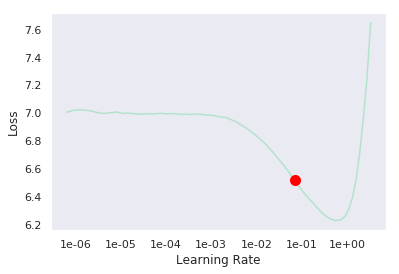

In [33]:
# find the learning rate
lm_learner.lr_find()
lm_learner.recorder.plot(suggestion=True)

In [34]:
# use mixed-precision training so that we can train faster and use a higher batch-size
lm_learner = lm_learner.to_fp16(clip=0.1)

Next we will train our model for 1 epoch at a learning rate of 4e-2, a weight decay of 0.1 and a momentum range between 0.8 and 0.7. 



In [35]:
# train 
lm_learner.fit_one_cycle(1, 4e-2, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.475519,3.908293,0.274490,0.725510,00:11


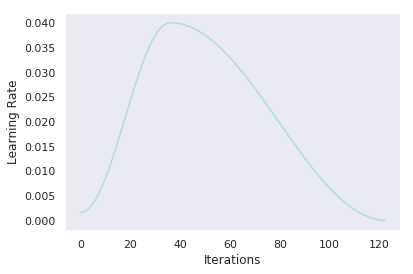

In [36]:
lm_learner.recorder.plot_lr()

<em>The plot above depicts the behavior of our learning rate during training</em>

One of the training methods proposed by Howard and Ruder is slanted triangular learning rates, a dynamic learning rate with a short increase and a long decay period.

This helps the model adapt parameters to task-specific features, making it quickly converge to a suitable region of the parameter space in the beginning of training and then refining its parameters. 

This slight derivation (because the fastai implementation has a smoother, curved and not strictly linear learning rate schedule) of [Leslie Smith's](https://arxiv.org/search/cs?searchtype=author&query=Smith%2C+L+N) triangular learning rates, which first linearly increase the learning rate and then linearly decay it according a dynamic update schedule.

![](https://miro.medium.com/max/548/1*QptmUluWXteT6oI5bD22rw.png)

STLR modifies triangular learning rates [(Smith, 2017)](https://arxiv.org/abs/1506.01186) with a short increase and a long decay period, which we found key for good performance.

We will then unfreeze the langauge model and train it for another 10 epochs at a lower learning rate of 2e-3.

In [37]:
# unfreeze model
lm_learner.unfreeze()

In [38]:
lm_learner.fit_one_cycle(10, 2e-3, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.922437,3.754492,0.295376,0.704624,00:15
1,3.742731,3.556616,0.323597,0.676403,00:15
2,3.501881,3.350708,0.355548,0.644452,00:15
3,3.234817,3.158594,0.388106,0.611894,00:15
4,2.962558,3.030422,0.416199,0.583801,00:15
5,2.764255,2.939293,0.434598,0.565402,00:15
6,2.581853,2.875347,0.449075,0.550925,00:15
7,2.441237,2.833311,0.458291,0.541709,00:15
8,2.345503,2.822308,0.462946,0.537054,00:15
9,2.294510,2.823497,0.463839,0.536161,00:15


In [39]:
lm_learner.save_encoder('fwd_enc_sg')

## Building the reverse language model

Next we will do the same with the backwards model data

In [40]:
# init backwards model
lm_backward = language_model_learner(data_lm_bwd, AWD_LSTM, metrics=[accuracy, error_rate]).to_fp16(clip=0.1)

In [41]:
# train for 1 epoch
lm_backward.fit_one_cycle(1, 4e-2, moms=(0.8,0.7), wd=0.1)
# unfreeze model 
lm_backward.unfreeze()
# train for another 10 epochs
lm_backward.fit_one_cycle(10, 2e-3, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.987548,4.032218,0.313452,0.686548,00:09


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.138949,3.898985,0.327026,0.672974,00:12
1,4.012778,3.748761,0.341577,0.658423,00:12
2,3.873624,3.612366,0.359106,0.640894,00:12
3,3.707471,3.431216,0.386279,0.613721,00:12
4,3.537629,3.313529,0.405713,0.594287,00:12
5,3.366531,3.222303,0.421509,0.578491,00:12
6,3.214743,3.158833,0.432813,0.567187,00:12
7,3.084675,3.121735,0.441528,0.558472,00:12
8,2.987851,3.106976,0.443872,0.556128,00:12
9,2.921696,3.104490,0.444824,0.555176,00:12


In [42]:
# set model directory so that encoder saves in the right directory
lm_backward.model_dir = '../../working'

In [43]:
lm_backward.save_encoder('bwd_enc_sg')

## Next we will train and fine-tune the classifier

<em>Classifier tuning</em>

To fine-tune the classifier the pre-trained language model has two extra linear blocks added to it. These are the only parameters that are trained from scratch, taking as inputs the pooled states from the last hidden layer in the language model. Each block uses batch normalization [(Ioffe and Szegedy, 2015)](https://arxiv.org/abs/1502.03167) and dropout, with ReLU activations for the intermediate layer and a softmax activation that outputs a probability distribution over target classes at the last layer.

In [44]:
# load the data for the forward classifier model using the language model vocabulary
fwd_data_clas = (TextList.from_df(df_train, vocab=data_lm.vocab, cols='text')
                          .split_by_rand_pct(0.15, seed=42) # 20% goes to validation set
                          .label_from_df(cols='airline_sentiment')
                          .databunch(bs=128))

In [45]:
fwd_data_clas.save('fwd_data_clas.pkl')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [46]:
# look at a batch of the data
fwd_data_clas.show_batch()

text,target
xxbos @united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup loudspeaker xxup on xxup flight 494 xxup atomic xxup number 2 xxup said xxup yes xxrep 4 ! xxup best xxup clarence xxup shepard xxup day xxup jr . xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
xxbos @virginamerica xxmaj many xxmaj thanks for the xxmaj follow . \n # ourprincess # freyasfund # xxup usa # xxmaj bandie \n xxmaj looking for xxmaj any xxmaj help 😍 \n 💗 🇬 🇧 💗 🇺 🇸 💗 \n 🎀 🌏 🎀 http : / / t.co / ujfs9zi6kd,neutral
"xxbos xxup by xxup the xxup grace xxup of xxup god , xxup atomic xxup number 53 xxup made xxup it ! “ @usairways : xxup xxunk _ _ xxmaj we do n't bear those xxunk in here . xxmaj we hope you rump attain that flight . ”",positive
"xxbos @usairways 4 segments , 4 / 4 delayed . xxmaj xxunk > xxup ctl . xxup ctl > xxup jan . xxup jan > xxup ctl . xxup ctl > xxup xxunk . xxmaj my year off from flying with you guys was the way to go .",negative
xxbos @united - xxmaj kid left a kindle fire xxup hd xxunk onboard xxup ua1037 ( xxup ord - xxup sfo ) today . xxmaj run in xxup 9abc - xxup def ( we had the whole row amongst the 5 of us ) . xxmaj help ...,neutral


In [47]:
# saving the backward data for the backwards model
bwd_data_clas = load_data(path, '../../working/fwd_data_clas.pkl', bs=bs, backwards=True)

In [48]:
# look at a batch of the backward model data
bwd_data_clas.show_batch()

text,target
! 6 xxrep much xxup so xxup u thank xxup ! ! ! ever xxup period xxup hour xxup four xxup twenty xxup best xxup ! 4 xxrep yes xxup said xxup helium xxup 494 steps xxup of xxup flight xxup on xxup loudspeaker xxup the xxup complete xxup prom xxup to xxup beau xxup my xxup asked xxup just xxup i @united xxbos,positive
! 6 xxrep much xxup so xxup u thank xxup ! ! ! ever xxup . jr xxup day xxup shepard xxup clarence xxup best xxup ! 4 xxrep yes xxup said xxup 2 number xxup atomic xxup 494 flight xxup on xxup loudspeaker xxup the xxup over xxup prom xxup to xxup boyfriend xxup my xxup asked xxup just xxup i @united xxbos,positive
? lax xxup - jac xxup for allowance bag check is what xxmaj g. xxup * 'm i . 10 / 13 dub xxup - lax xxup 10 / 8 lax xxup - jac xxup 9 / 29 jac xxup - dub xxup . problems xxmaj booking xxmaj flight xxmaj future re question a deliver xxunk xxmaj @united xxbos,neutral
m xxunk xxup . human xxup a call xxup to xxup number xxup a me xxup give xxup or xxup now xxup me xxup tell xxup ? ? ? bag fucking my is fuck the where xxmaj ! ? ! ? bag xxup fucking xxup my xxup is xxup where xxup @united xxbos,negative
! future xxmaj in xxmaj u like xxmaj corp. xxmaj for xxmaj pedestal xxmaj xxunk xxmaj an xxmaj be xxup will xxup we xxmaj ! honorable xxmaj is xxmaj class xxmaj a months xxmaj xxunk month calendar xxmaj history xxmaj xxunk xxmaj see xxmaj u that xxmaj fact xxmaj the xxmaj @southwestair xxbos,positive


In [49]:
# initiate the classifier for the forward data
fwd_clas = text_classifier_learner(fwd_data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False, metrics=[accuracy, error_rate])

>We need to move some files around to make this work in the Kaggle notebook

In [50]:
# move encoder to correct directory
!mv ../../working/fwd_enc_sg.pth ./fwd_enc_sg.pth

In [51]:
# create models directory and move encoder there
!mkdir models; mv ./fwd_enc_sg.pth models/fwd_enc_sg.pth

>Next we will load the encoder we trained earlier into the classifier

In [52]:
# load the language model encoder into the classifer
fwd_clas.load_encoder('fwd_enc_sg')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (19230 items)
x: TextList
xxbos @virginamerica xxmaj what @dhepburn said .,xxbos @virginamerica plus you 've added commercials to the experience ... tacky .,xxbos @virginamerica i did n't today ... xxmaj must mean i need to take another trip !,xxbos @virginamerica it 's really aggressive to xxunk xxunk " entertainment " in your guests ' faces & & they have little recourse,xxbos @virginamerica and it 's a really big bad thing about it
y: CategoryList
neutral,positive,neutral,negative,negative
Path: .;

Valid: LabelList (3393 items)
x: TextList
xxbos @united do you have got an e - mail address i commode write my account statement to ? xxmaj might be to a xxunk extent potential to disappear,xxbos @united thanks for the effort . xxup iodine can get the earliest . xxmaj though i testament make a ill for a repayment as i am losing unrivaled business day tomorrow,xxbos @united somehow i knew that you 'd wait until i was xxunk to respond . #

<em>Gradual unfreezing</em>

Instead of fine-tuning all the layers at once (which may break our model and cause catastophic forgetting) Ruder and Howard propose training the model by gradually unfreezing layers, layer by layer - starting at the last layer. We also decrease our learning rate as we train deeper layers in the model. Models in the earlier layers contain more general knowledge and therefore need to be trained less [(Yosinski et al., 2014)](https://arxiv.org/abs/1411.1792).

In [53]:
# train last layer
lr = 1e-1
fwd_clas.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.562405,0.523056,0.801356,0.198644,00:06


In [54]:
# train last two layers
fwd_clas.freeze_to(-2)
lr /= 2
fwd_clas.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.454430,0.358934,0.866195,0.133805,00:07


In [55]:
# train last three layers
fwd_clas.freeze_to(-3)
lr /= 2
fwd_clas.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.372695,0.270985,0.902446,0.097554,00:11


In [56]:
# train all layers
fwd_clas.unfreeze()
lr /= 5
fwd_clas.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.209316,0.234857,0.927792,0.072207,00:14
1,0.121347,0.224918,0.936339,0.063660,00:14


In [57]:
fwd_clas.save('fwd_clas_cp')

In [58]:
# train the classifer a little more
fwd_clas.fit_one_cycle(3, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.108921,0.227984,0.929266,0.070734,00:14
1,0.087521,0.216044,0.942234,0.057766,00:14
2,0.054465,0.224601,0.944592,0.055408,00:14


In [59]:
# train the classifer a little more
#fwd_clas.fit_one_cycle(3, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

In [60]:
fwd_clas.save('fwd_clas_fin')

Our forward classifier has a validation error rate of 5.5%.

### Classifier in reverse

>Training the reverse clasifier with the same hyper parameters as the forward model

In [61]:
bwd_clas = text_classifier_learner(bwd_data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False, metrics=[accuracy, error_rate])

In [62]:
bwd_clas.model_dir = '../../working'

In [63]:
bwd_clas.load_encoder('bwd_enc_sg')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (19230 items)
x: TextList
xxbos @virginamerica xxmaj what @dhepburn said .,xxbos @virginamerica plus you 've added commercials to the experience ... tacky .,xxbos @virginamerica i did n't today ... xxmaj must mean i need to take another trip !,xxbos @virginamerica it 's really aggressive to xxunk xxunk " entertainment " in your guests ' faces & & they have little recourse,xxbos @virginamerica and it 's a really big bad thing about it
y: CategoryList
neutral,positive,neutral,negative,negative
Path: .;

Valid: LabelList (3393 items)
x: TextList
xxbos @united do you have got an e - mail address i commode write my account statement to ? xxmaj might be to a xxunk extent potential to disappear,xxbos @united thanks for the effort . xxup iodine can get the earliest . xxmaj though i testament make a ill for a repayment as i am losing unrivaled business day tomorrow,xxbos @united somehow i knew that you 'd wait until i was xxunk to respond . #

In [64]:
# train only the last layer
bwd_clas.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.718984,0.644077,0.718243,0.281757,00:06


Gradual unfreezing of the layers for the backward model...

In [65]:
# train the last two layers
bwd_clas.freeze_to(-2)
lr /= 2
bwd_clas.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.654930,0.567373,0.774536,0.225464,00:06


In [66]:
# train the last 3 layers
bwd_clas.freeze_to(-3)
lr /= 2
bwd_clas.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.579882,0.504336,0.806661,0.193339,00:09


In [67]:
# train all the layers
bwd_clas.unfreeze()
lr /= 5
bwd_clas.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.549169,0.475929,0.820218,0.179782,00:12
1,0.523580,0.469919,0.818155,0.181845,00:11


In [68]:
# train a little bit more
bwd_clas.fit_one_cycle(3, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.506550,0.461093,0.823460,0.176540,00:12
1,0.512611,0.445438,0.827586,0.172414,00:12
2,0.494365,0.450012,0.826702,0.173298,00:12


In [69]:
# and a little bit more
bwd_clas.fit_one_cycle(3, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.497543,0.428264,0.829355,0.170645,00:12
1,0.469457,0.414432,0.834365,0.165635,00:12
2,0.447166,0.428062,0.827881,0.172119,00:11


Training the backward classifier for longer appears to improve model performance.

In [70]:
# train an extra 15 epochs
bwd_clas.fit_one_cycle(15, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.452121,0.420075,0.833775,0.166225,00:12
1,0.449883,0.413575,0.836133,0.163867,00:12
2,0.435257,0.401660,0.841144,0.158856,00:11
3,0.423563,0.394542,0.842322,0.157678,00:11
4,0.413985,0.381080,0.851459,0.148541,00:12
5,0.411278,0.356462,0.862658,0.137342,00:12
6,0.391391,0.349721,0.863248,0.136752,00:11
7,0.377484,0.352287,0.863543,0.136457,00:12
8,0.376299,0.334311,0.873563,0.126437,00:12
9,0.346740,0.338156,0.872974,0.127026,00:11


In [71]:
# checkpoint
bwd_clas.save('bwd_clas_fin')

<strong>Next we will calculate the ensemble model predictions</strong>

We do this by taking the mean predictions of both models combined.

In [72]:
# get forward classifier predictions and accuracy for validation set
fwd_preds, fwd_targets = fwd_clas.get_preds(ordered=True)
print('Forward classifier results (validation set): \nValidation accuracy: {:.2f}, Validation error rate: {:.2f}'.format(accuracy(fwd_preds, fwd_targets), error_rate(fwd_preds, fwd_targets)))

Forward classifier results (validation set): 
Validation accuracy: 0.94, Validation error rate: 0.06


In [73]:
# get backward classifier predictions and accuracy for validation set
bwd_preds, bwd_targets = bwd_clas.get_preds(ordered=True)
print('Backward classifier results (validation set): \nValidation accuracy: {:.2f}, Validation error rate: {:.2f}'.format(accuracy(bwd_preds, bwd_targets), error_rate(bwd_preds, bwd_targets)))

Backward classifier results (validation set): 
Validation accuracy: 0.88, Validation error rate: 0.12


In [74]:
# get combined(mean) predictions
ensemble_preds = (fwd_preds + bwd_preds)/2
# get combined(mean) accuracy on validation set
print('Ensemble classifier results (validation set): \nValidation accuracy: {:.2f}, Validation error rate: {:.2f}'.format(accuracy(ensemble_preds, fwd_targets), error_rate(ensemble_preds, fwd_targets)))

Ensemble classifier results (validation set): 
Validation accuracy: 0.94, Validation error rate: 0.06


## How well does the model generalize?

Now that we've built our bi-directional classifier we want to see how well it generalizes. Let's test the model's performance on our test set.

In [75]:
# load the test data using datablock api - a somewhat hacky but quick way to load the test set into the model
data_test = (TextList.from_df(df_test, vocab=data_lm.vocab, cols='text')
                          .split_subsets(train_size=0.01, valid_size=0.99) # the hacky part
                          .label_from_df(cols='airline_sentiment')
                          .databunch(bs=128))

You can deactivate this warning by passing `no_check=True`.


/opt/conda/lib/python3.6/site-packages/fastai/basic_data.py:247: UserWarning: Your training dataloader is empty, you have only 21 items in your training set.
                 Your batch size is 128, you should lower it.
  Your batch size is {self.train_dl.batch_size}, you should lower it.""")


In [76]:
# load data into forward classifier
fwd_clas.data = data_test

In [77]:
# hacky solution comes at a price - sometimes not all labels are loaded into the model
assert fwd_clas.data.c == 3

In [78]:
# save test data
data_test.save('test_data.pkl')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [79]:
# save backward test data
bwd_test = load_data(path, '../../working/test_data.pkl', bs=bs, backwards=True)

You can deactivate this warning by passing `no_check=True`.


/opt/conda/lib/python3.6/site-packages/fastai/basic_data.py:247: UserWarning: Your training dataloader is empty, you have only 21 items in your training set.
                 Your batch size is 256, you should lower it.
  Your batch size is {self.train_dl.batch_size}, you should lower it.""")


In [80]:
# load data into backward classifier
bwd_clas.data = bwd_test

In [81]:
# hacky solution comes at a price - sometimes not all labels are loaded into the model
assert bwd_clas.data.c == 3

In [82]:
# get foward model predictions on test set
test_preds, test_targs = fwd_clas.get_preds(ds_type=DatasetType.Valid)
print('Forward classifier results (test set): \nTest accuracy: {:.2f}, Test error rate: {:.2f}'.format(accuracy(test_preds, test_targs), error_rate(test_preds,test_targs)))

Forward classifier results (test set): 
Test accuracy: 0.85, Test error rate: 0.15


In [83]:
# get backward model predictions on test set
bwdt_preds, bwdt_targs = bwd_clas.get_preds(ds_type=DatasetType.Valid)
print('Backward classifier results (test set): \nTest accuracy: {:.2f}, Test error rate: {:.2f}'.format(accuracy(bwdt_preds, bwdt_targs),error_rate(bwdt_preds, bwdt_targs)))

Backward classifier results (test set): 
Test accuracy: 0.85, Test error rate: 0.15


In [84]:
# get bi-directional model predictions
ensemble_preds = (test_preds + bwdt_preds)/2
# Get ensemble error
# higher precision reporting - to be able to inspect model performance closer
print('Ensemble classifier results (test set): \nTest accuracy: {:.4f}, Test error rate: {:.4f}'.format(accuracy(ensemble_preds, test_targs),error_rate(ensemble_preds, test_targs)))

Ensemble classifier results (test set): 
Test accuracy: 0.8602, Test error rate: 0.1398


## Model Evaluation

Our ensemble model returns an error rate of 13.98% on the test set and 5.5% error on our validation set, an improvement on our benchmark's test error rate of 17.2%. Let's inspect the model's performance a little closer by looking at a classification matrix that plots the true vs. the predicted labels.

In [85]:
# prepare data for confusion matrix
y_pred = np.array(np.argmax(ensemble_preds, axis=1))
y_true = np.array(test_targs)

In [86]:
# quick check if all classes are present
print(y_pred)
print(y_true)

[1 0 0 0 ... 2 1 1 1]
[1 0 0 0 ... 2 1 0 0]


## Classification Matrix

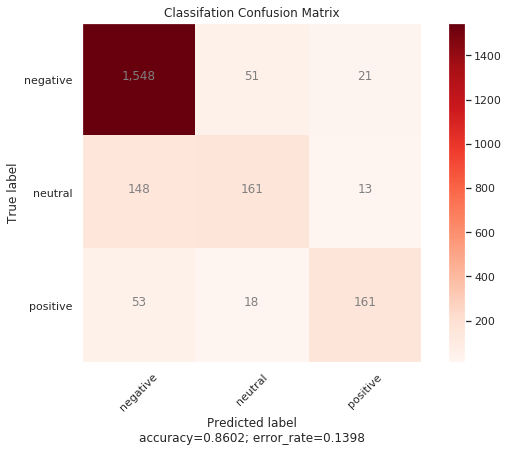

In [87]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cmap = 'Reds'
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=cmap, normalize=False):
  acc = np.trace(cm) / float(np.sum(cm))
  err_rate = 1 - acc
  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  if target_names is not None:
      tick_marks = np.arange(len(target_names))
      plt.xticks(tick_marks, target_names, rotation=45)
      plt.yticks(tick_marks, target_names)
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  thresh =  cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):      
      if normalize:
          plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                   horizontalalignment="center",
                   color="grey" if cm[i, j] > thresh else "grey")
      else:
          plt.text(j, i, "{:,}".format(cm[i, j]),
                   horizontalalignment="center",
                   color="grey" if cm[i, j] > thresh else "grey")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; error_rate={:0.4f}'.format(acc, err_rate))
  plt.show()
    
    
plot_confusion_matrix(cm=cm, target_names=['negative', 'neutral', 'positive'], 
                      title='Classifation Confusion Matrix')

The figure above shows both the test set's true labels and our model's predictions.

Our model makes the least errors when given a negative tweet with the lowest error rate of around 4.4%.

It makes significantly more mistakes when the inputs are neutral or positive tweets with an error rate of 49% for neutral tweets (nearly half), and an eror rate of 30.6% (around a third) when given positive tweets.

The most common error seems to be confusing neutral with negative tweets, which may still be a symptom of the class imbalance. I'm also guessing that neutral tweets probably contain fewer or no words that signal the tweet's sentiment, possibly making it harder for the network to classify?

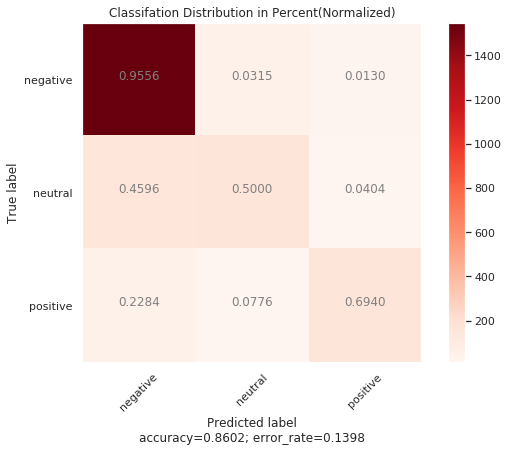

In [88]:
plot_confusion_matrix(cm=cm, target_names=['negative', 'neutral', 'positive'], 
                      title='Classifation Distribution in Percent(Normalized)', normalize=True)

## Conclusion

This was a fun challenge and a great learning experience, given that this was my first time working on a natural language processing (NLP) related task. I hope that this notebook can be of use to others looking to learn more about creating an ULMFiT classifier. 

It would be interesting to see if the model can be improved by testing more recent approaches to generating text using language models or possibly transformers.

Below is a list of helpful links with NLP learning resources.

- [ULMFiT Paper Arxiv Link](https://arxiv.org/abs/1801.06146)
- [Fast.ai NLP Classification Resources](http://nlp.fast.ai/category/classification.html)
- [Sebastian Ruder's Blog](http://ruder.io/)
- [Fast.ai NLP MOOC](https://www.youtube.com/playlist?list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9)